# Analyzing subject mentions

**subject mentions** == The subject mentioning other users.

We will be looking at two things:
- distribution of total mentions
- top-K mentioned people (and how many times they were mentioned)

*Total mentions* == Sum of all the mentions of one subject.

## Some conclusions
Ran with the following numbers:
```
N_SUBJECTS = 100
TOP_K_MENTIONS = 15
N_TWEETS = 500
```
- Total number of mentions are between 0-200 for ~200 tweets / user.
- It seems like most users mention only a handful of users (1-5) more frequently.

__Notes__:
We also looked at *mutual* mentions -- unfortunately among the first 100 subjects there were none, thus I excluded them from the analysis.

In [1]:
%load_ext dotenv
%dotenv 

In [3]:
N_SUBJECTS = 100
TOP_K_MENTIONS = 15
N_TWEETS = 500

In [4]:
mongo_conn = MongoClient(os.environ["MONGO_CONN"])
db = mongo_conn.twitter  # our database

subjects_collection = db["subjects_collection"]
timelines_collection = db["timelines_collection"]
mentions_collection = db["mentions_collection"]

Get cursor for subjects

In [5]:
# set_RT_ratio = {
#     "$set": {"RT_ratio": {"$divide": ["$num_RT_tweets", "$num_pulled_tweets"]}},
# }

# subjects_filter = {
#     "$match": {
#         "error_or_no_access": False,
#         "majority_lang": "en",
#         "num_pulled_tweets": {"$gt": 0},
#         "tweet_count": {"$gt": 200},
#         "RT_ratio": {"$lt": 0.8},
#         "bot_score.raw_scores.english.overall": {"$lt": 0.5},
#     }
# }

# limit = {"$limit": N_SUBJECTS}

# cursor = sampled_users_collection.aggregate([set_RT_ratio, subjects_filter, limit])

In [6]:
cursor = subjects_collection.find().limit(N_SUBJECTS)

In [7]:
subjects = []

for s in cursor:
    data = {
        "username": s["username"],
        "mentions": Counter(),
        # "mentioned_by": Counter(),
        "total_mentions": 0,
        # "total_mentioned_by": 0,
        "num_tweets": 0,
    }
    
    user_timeline_no_RT = {
        "author_id": s["id"],
        "referenced_tweets.0.type": {"$ne": "retweeted"},
        "lang": "en",
    }
    
    # timeline
    data["num_tweets"] = timelines_collection.count_documents(user_timeline_no_RT)
    t_cursor = timelines_collection.find(user_timeline_no_RT).limit(N_TWEETS)
    
    for t in t_cursor:
        if "entities" in t and "mentions" in t["entities"]:
            usernames = [mention["username"] for mention in t["entities"]["mentions"]]
            data["mentions"] = data["mentions"] + Counter(usernames)
    
    data["total_mentions"] = len(list(data["mentions"].elements()))
    
#     user_mentions = {
#         "mentioned_user_id": s["id"],
#     }
    
#     # mentions timeline
#     m_cursor = mentions_collection.find(user_mentions)
#     for m in m_cursor:
#         data["mentioned_by"] = data["mentioned_by"] + Counter([m["id"]])
        
#     data["total_mentioned_by"] = len(list(data["mentioned_by"].elements()))
    
    subjects.append(data)
        
subjects = sorted(subjects, key=lambda d: d["total_mentions"]) # sort subjects by total mentions

In [8]:
subjects

[{'username': 'metacritic',
  'mentions': Counter({'DawnX90': 1,
           'danielletbd': 1,
           'TVGuide': 1,
           'MeggoInc': 1,
           'GameSpot': 1,
           'ChrisHayner': 1,
           'UniversalPics': 1,
           'mgmstudios': 1,
           'NaughtyNDC': 1,
           'rosalia': 2,
           'chartdata': 1,
           'TheAcademy': 1,
           'Super70sSports': 1}),
  'total_mentions': 14,
  'num_tweets': 599},
 {'username': 'KobeLambeth',
  'mentions': Counter({'mondo_45': 1,
           'AveryHage': 1,
           'allsportsfan24': 7,
           'folzyfantasy15': 3,
           'FBCapitolOfNC': 1,
           'sdotpeso': 1,
           'bcschneider53': 3,
           'Officialmkmoore': 1,
           'GridRanking': 2,
           'ChrisGould88': 2,
           'WBTV_News': 1,
           'DontreGraves': 1,
           'jack': 1,
           'SethEggert91': 1,
           'THProject91': 1,
           'DGIveyNASCARFan': 1,
           'aaronbearden93': 1,
           '

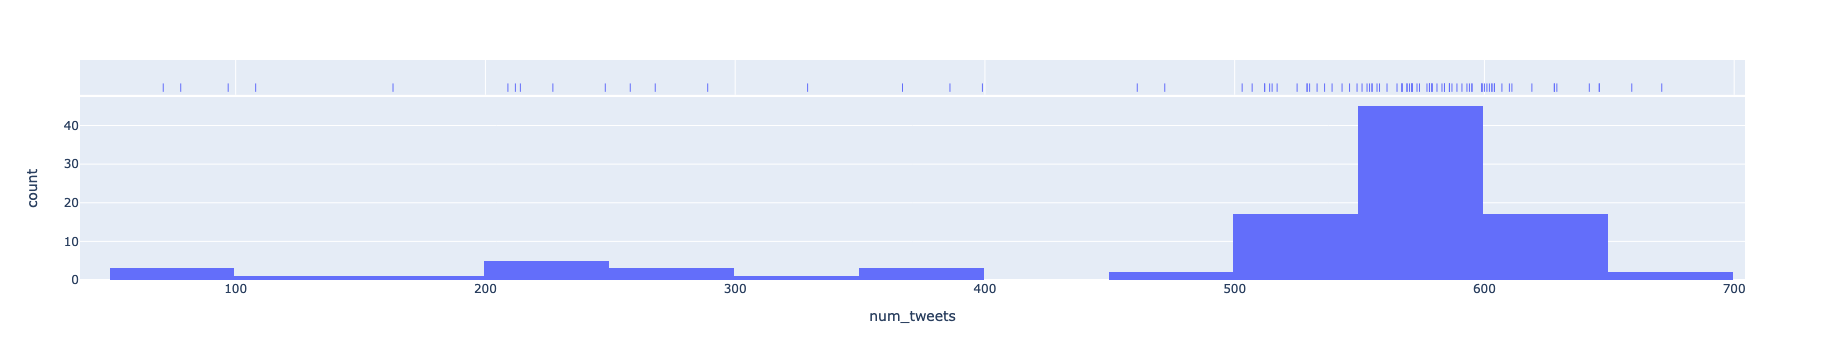

In [9]:
px.histogram(subjects, x="num_tweets", marginal="rug", hover_name="username")

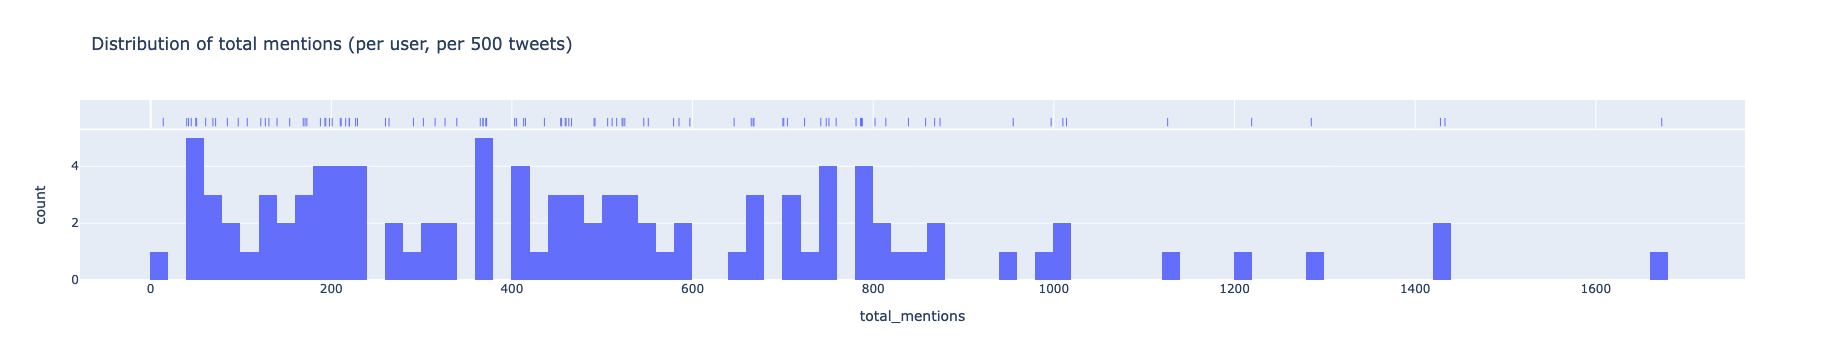

In [10]:
px.histogram(subjects, x="total_mentions", nbins=100, labels={"x": "Number of total mentions"}, marginal="rug", hover_name="username", title="Distribution of total mentions (per user, per %d tweets)" % N_TWEETS)

In [17]:
subjects[0]["mentions"].most_common(15)

[('rosalia', 2),
 ('DawnX90', 1),
 ('danielletbd', 1),
 ('TVGuide', 1),
 ('MeggoInc', 1),
 ('GameSpot', 1),
 ('ChrisHayner', 1),
 ('UniversalPics', 1),
 ('mgmstudios', 1),
 ('NaughtyNDC', 1),
 ('chartdata', 1),
 ('TheAcademy', 1),
 ('Super70sSports', 1)]

In [12]:
data = {
    "subjects": [],
    "top-k": [],
    "mentioned_user": [],
    "mentions": []
}

for s in subjects:
    k = 0
    for uname, n_mentions in s["mentions"].most_common():
        if k >= TOP_K_MENTIONS:
            break
        k += 1
        data["subjects"].append(s["username"])
        data["top-k"].append(str(k))
        data["mentioned_user"].append(uname)
        data["mentions"].append(n_mentions)

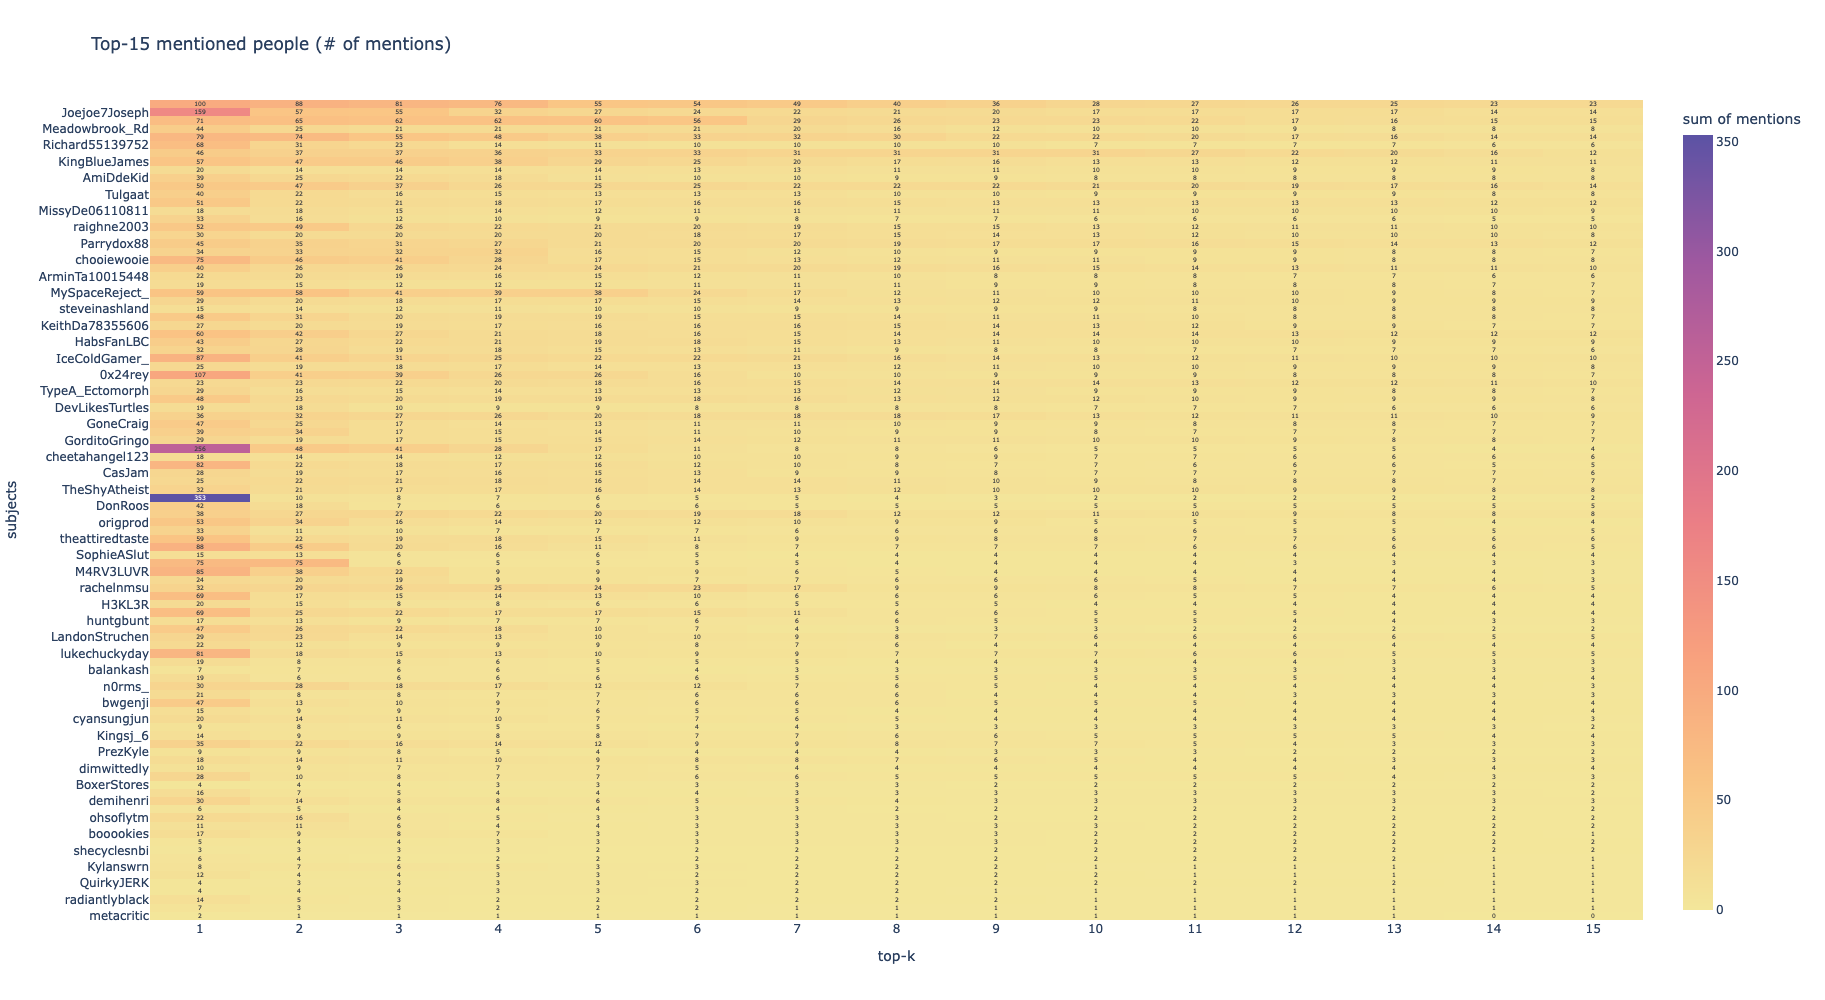

In [13]:
df = pd.DataFrame.from_dict(data)

fig = px.density_heatmap(df, x="top-k", y="subjects", z="mentions", text_auto=True, height=1000, color_continuous_scale="sunset", title="Top-%d mentioned people (# of mentions)" % TOP_K_MENTIONS)
fig.update_xaxes(type='category')
fig.show()

In [14]:
df[df["subjects"] == "AnthonyAllenYT"]

subjects top-k   mentioned_user  mentions
763  AnthonyAllenYT     1          YouTube       353
764  AnthonyAllenYT     2    YouTubeGaming        10
765  AnthonyAllenYT     3         Juani983         8
766  AnthonyAllenYT     4       TheMelaLee         7
767  AnthonyAllenYT     5         elonmusk         6
768  AnthonyAllenYT     6   kemetnubiakamp         5
769  AnthonyAllenYT     7     FortniteGame         5
770  AnthonyAllenYT     8   TheNicolasRoye         4
771  AnthonyAllenYT     9  YouTubeCreators         3
772  AnthonyAllenYT    10        tiktok_uk         2
773  AnthonyAllenYT    11    TikTokSupport         2
774  AnthonyAllenYT    12           EAHelp         2
775  AnthonyAllenYT    13       CaffeinaTL         2
776  AnthonyAllenYT    14        sweeetanj         2
777  AnthonyAllenYT    15    TwinCitiesCon         2

In [15]:
df[df["mentions"] == 256]

subjects top-k mentioned_user  mentions
853  v1ru3_o     1      EpicGyall       256

Maybe filter out verified businesses from peers? - **No**, doesn't really pay off...

`verified_type: 'business'` (< 1% of accounts in users_collection, other types: `'blue'`). 

VERY new feature: [added](https://github.com/twitter-dart/twitter-api-v2/issues/646) on Feb 2nd 2023!

Examples:

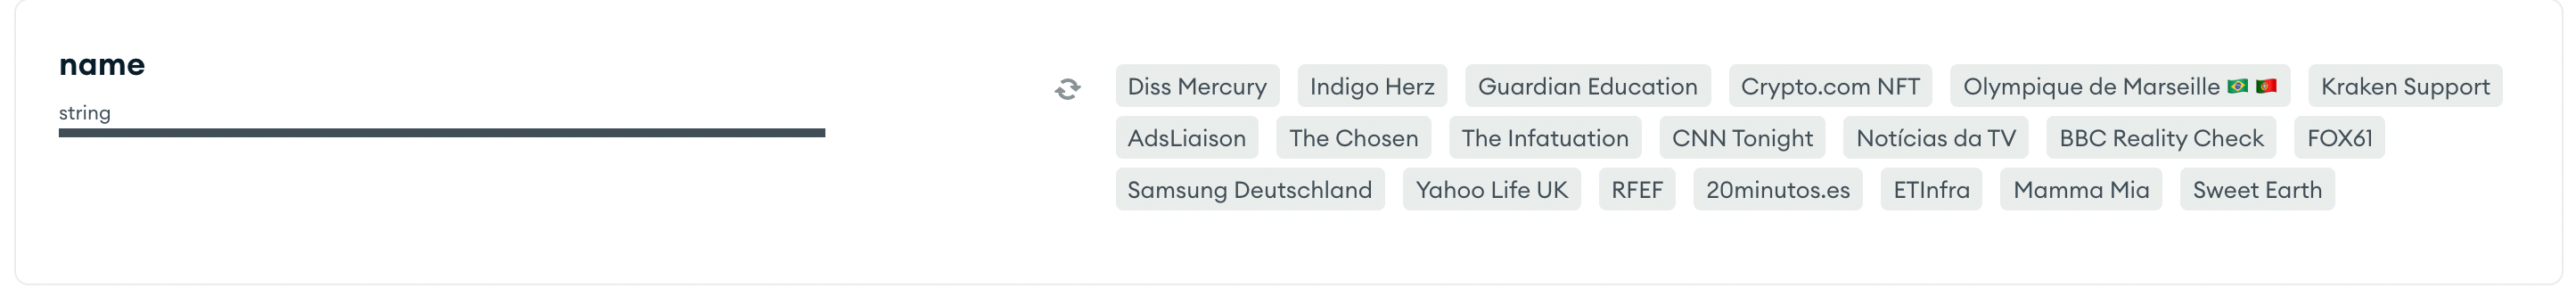

### Test plots on dummy data

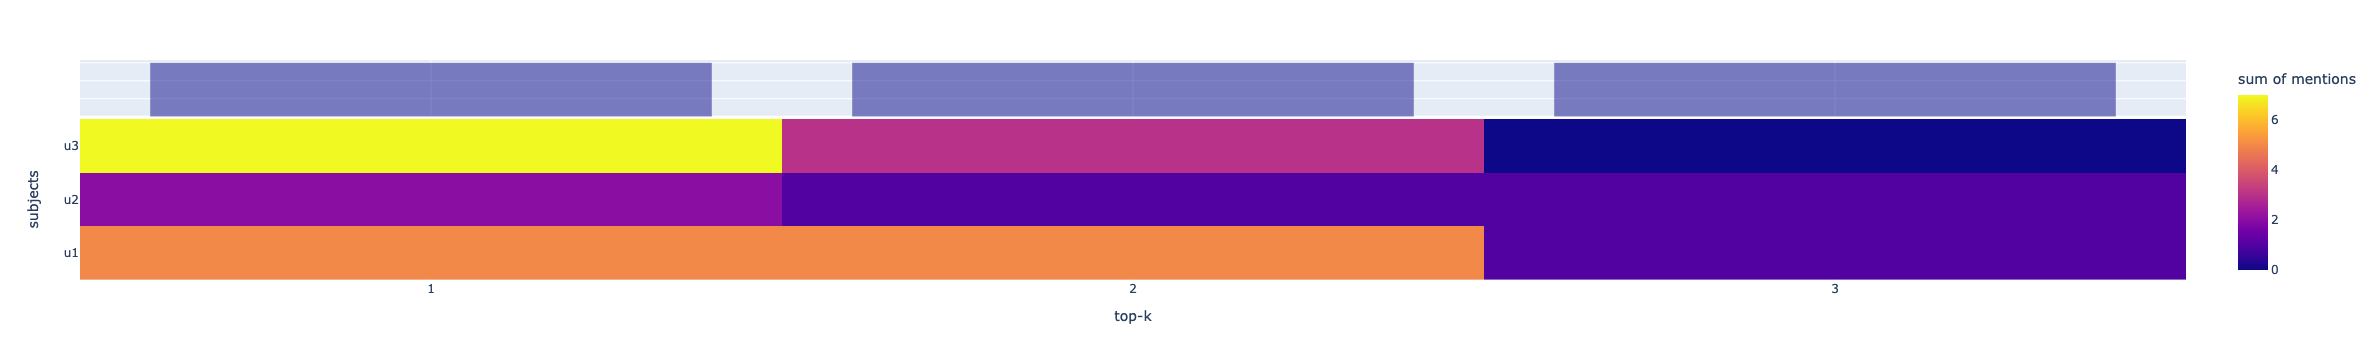

In [16]:
dummy_data = {
    "subjects": ["u1", "u1", "u1", "u2", "u2", "u2", "u3", "u3", "u3"],
    "top-k": ["1", "2", "3", "1", "2", "3", "1", "2", "3"],
    "mentions": [5, 5, 1, 2, 1, 1, 7, 3, 0]
}

df = pd.DataFrame.from_dict(dummy_data)

fig = px.density_heatmap(df, x="top-k", y="subjects", z="mentions", marginal_x="histogram")
fig.show()